<a href="https://colab.research.google.com/github/WahyuBagus8545/garbage-classification/blob/main/garbage_classification_nn_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mohammad Wahyu Bagus Dwi Satya

bagus8545@gmail.com

Sumber data : https://www.kaggle.com/datasets/mostafaabla/garbage-classification

Note
I run this on the kaggle notebook

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

!mkdir /content/drive/MyDrive/APIToken
!cp kaggle.json /content/drive/MyDrive/APIToken/

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/APIToken/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

In [ ]:
download_path = "/content/garbage-classification.zip"
extract_path = "/content/garbage-classification"
!unzip -q {download_path} -d {extract_path}

In [ ]:
base_dir = '/kaggle/input/garbage-classification/garbage_classification'

In [ ]:
from PIL import Image
import os

# Function to read image files in a directory and its subdirectories
def read_files(startpath):
    image_files = []
    for dirname, dirnames, filenames in os.walk(startpath):
        for filename in filenames:
            image_files.append(os.path.join(dirname, filename))
    return image_files

# Retrieve all image file paths
full_dirs = read_files(base_dir)

# Lists to store image sizes and count of image files
image_sizes = []
num_image_files = 0

# Iterate through each image file
for file in full_dirs:
    # Open image using PIL
    try:
        image = Image.open(file)
        width, height = image.size
        image_sizes.append(f'{width}x{height}')
        num_image_files += 1
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Get unique image sizes
unique_sizes = set(image_sizes)

# Print results
print(f'Total number of image files: {num_image_files}')
print(f'Total number of unique image sizes: {len(unique_sizes)}')
print(f'First 5 unique image sizes: \n{list(unique_sizes)[:5]}')from PIL import Image
import os

# Function to read image files in a directory and its subdirectories
def read_files(startpath):
    image_files = []
    for dirname, dirnames, filenames in os.walk(startpath):
        for filename in filenames:
            image_files.append(os.path.join(dirname, filename))
    return image_files

# Retrieve all image file paths
full_dirs = read_files(base_dir)

# Lists to store image sizes and count of image files
image_sizes = []
num_image_files = 0

# Iterate through each image file
for file in full_dirs:
    # Open image using PIL
    try:
        image = Image.open(file)
        width, height = image.size
        image_sizes.append(f'{width}x{height}')
        num_image_files += 1
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Get unique image sizes
unique_sizes = set(image_sizes)

# Print results
print(f'Total number of image files: {num_image_files}')
print(f'Total number of unique image sizes: {len(unique_sizes)}')
print(f'First 5 unique image sizes: \n{list(unique_sizes)[:5]}')

Total number of image files: 15515
Total number of unique image sizes: 892
First 5 unique image sizes: 
['400x495', '200x133', '282x178', '174x289', '289x174']


In [ ]:
import numpy as np
from keras.preprocessing.image import img_to_array

def custom_preprocess(input_data, target_size=(224, 224), convert_to_rgba=True):
    if isinstance(input_data, str):  # Check if input is a file path
        img = Image.open(input_data)
    elif isinstance(input_data, np.ndarray):  # Check if input is a NumPy array
        img = Image.fromarray((input_data * 255).astype(np.uint8))  # Convert to PIL Image
    else:
        raise ValueError("Unsupported input type. Must be either a file path or a NumPy array.")

    # Convert to RGBA format if specified
    if convert_to_rgba and img.mode != 'RGBA':
        img = img.convert('RGBA')

    # Convert palette images with transparency to RGBA
    if img.mode == 'P' and 'transparency' in img.info:
        img = img.convert('RGBA')

    # Resize the image with LANCZOS resampling (replacing ANTIALIAS)
    img = img.resize(target_size, Image.LANCZOS)

    # Convert back to RGB if needed
    img = img.convert('RGB')

    # Convert PIL Image to NumPy array
    img_array = img_to_array(img)

    return img_array

2024-02-07 15:08:54.976353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 15:08:54.976454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 15:08:55.121479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

IDG = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    #preprocessing_function=lambda x: custom_preprocess(x, target_size=(227, 227), convert_to_rgba=True)
)

In [ ]:
training_generator = IDG.flow_from_directory(
  base_dir,
  shuffle=True,
  subset='training',
  target_size=(224,224),
  class_mode='categorical'
)

validation_generator = IDG.flow_from_directory(
  base_dir,
  subset='validation',shuffle=False,
  target_size=(224,224),
  class_mode='categorical'
)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input

pre_trained_model =ResNet50V2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224,224, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = True

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

num_classes=12

model = Sequential([
    pre_trained_model,
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
class AccuracyStopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        target_accuracy = 0.92

        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')  # Corrected key

        if current_accuracy is not None and current_val_accuracy is not None:
            if current_accuracy >= target_accuracy and current_val_accuracy >= target_accuracy:
                print('\nAccuracy reached 92% on both training and validation sets.')
                self.model.stop_training = True
stop_callback = AccuracyStopCallback()

In [ ]:
history = model.fit(
    training_generator,
    epochs=200,
    validation_data=validation_generator,
    verbose=1,
    shuffle=True,
    callbacks=[stop_callback]
)

Epoch 1/200


I0000 00:00:1707318570.169526     146 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 [==============================] - 115s 210ms/step - loss: 3.8843 - accuracy: 0.8194 - val_loss: 3.2595 - val_accuracy: 0.8823
Epoch 2/200
388/388 [==============================] - 75s 193ms/step - loss: 2.6246 - accuracy: 0.9510 - val_loss: 2.4607 - val_accuracy: 0.8861
Epoch 3/200
388/388 [==============================] - 74s 191ms/step - loss: 1.8773 - accuracy: 0.9758 - val_loss: 1.8377 - val_accuracy: 0.9084
Epoch 4/200
388/388 [==============================] - 74s 191ms/step - loss: 1.3779 - accuracy: 0.9791 - val_loss: 1.4897 - val_accuracy: 0.9052
Epoch 5/200
388/388 [==============================] - 74s 191ms/step - loss: 1.0063 - accuracy: 0.9828 - val_loss: 1.2949 - val_accuracy: 0.8794
Epoch 6/200
388/388 [==============================] - 75s 192ms/step - loss: 0.7624 - accuracy: 0.9811 - val_loss: 0.8912 - val_accuracy: 0.9177
Epoch 7/200
388/388 [==============================] - 75s 192ms/step - loss: 0.5667 - accuracy: 0.9849 - val_loss: 0.8092 - val_accura

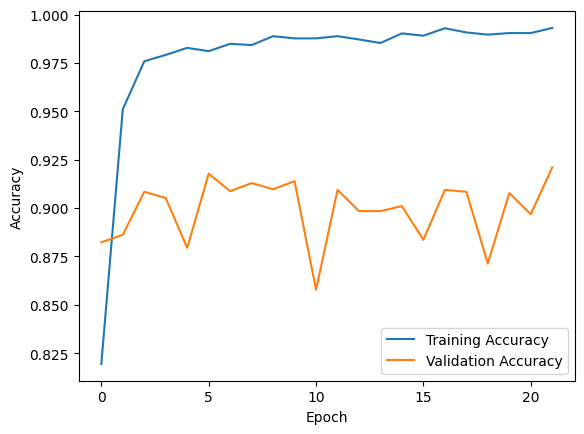

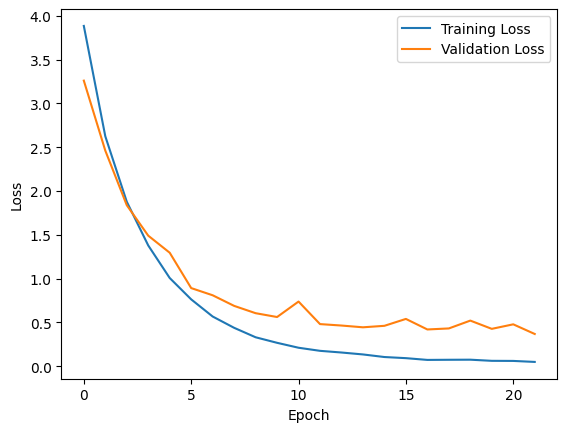

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi dan loss model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Menyimpan model ke dalam format TF-Lite
model.save('content/model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('content/model.tflite', 'wb') as f:
    f.write(tflite_model)


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 149, Total Ops 283, % non-converted = 52.65 %
 * 149 ARITH ops

- arith.constant:  149 occurrences  (f32: 146, i32: 3)



  (f32: 33)
  (f32: 54)
  (f32: 2)
  (f32: 5)
  (f32: 17)
  (f32: 18)
  (f32: 1)
  (f32: 1)
